# Text Classification competition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from transformers import BertForSequenceClassification, AdamW

from transformers import BertTokenizer, BertForSequenceClassification, GPT2Tokenizer
from transformers import AdamW

In [2]:
df_train = pd.read_csv('/kaggle/input/nn-text/train.csv')
df_test = pd.read_csv('/kaggle/input/nn-text/test.csv')
sample_submission = pd.read_csv('/kaggle/input/nn-text/sample_submission.csv')

## EDA

In [3]:
df_train.head()

,Unnamed: 0,Review,Rating
0,0,foliage silhouette perfect european getaway ho...,4
1,1,characterized recommendng clean safe hotel hus...,4
2,2,"seaweed avoidwe spectacular, booked trip bj wh...",5
3,3,"week__ç_é_ doona ca n't wait return, hotel mag...",5
4,4,choppy marched super budget hotel hubby stayed...,5


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14343 entries, 0 to 14342
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  14343 non-null  int64 
 1   Review      14343 non-null  object
 2   Rating      14343 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 336.3+ KB


In [5]:
df_train.describe()

,Unnamed: 0,Rating
count,14343.000000,14343.000000
mean,7171.000000,4.298822
std,4140.611791,18.616717
min,0.000000,1.000000
25%,3585.500000,3.000000
50%,7171.000000,4.000000
75%,10756.500000,5.000000
max,14342.000000,999.000000


In [6]:
df_train = df_train.drop('Unnamed: 0', axis = 1)

In [7]:
df_train['Rating'].value_counts()

Rating
5      6334
4      4226
3      1528
2      1255
1       995
999       5
Name: count, dtype: int64

In [8]:
df_train.head()

,Review,Rating
0,foliage silhouette perfect european getaway ho...,4
1,characterized recommendng clean safe hotel hus...,4
2,"seaweed avoidwe spectacular, booked trip bj wh...",5
3,"week__ç_é_ doona ca n't wait return, hotel mag...",5
4,choppy marched super budget hotel hubby stayed...,5


In [9]:
df_train = df_train[df_train['Rating'] < 6]

In [10]:
df_train['Review']

0        foliage silhouette perfect european getaway ho...
1        characterized recommendng clean safe hotel hus...
2        seaweed avoidwe spectacular, booked trip bj wh...
3        week__ç_é_ doona ca n't wait return, hotel mag...
4        choppy marched super budget hotel hubby stayed...
                               ...                        
14338    continential rashes great spot, stayed wife ac...
14339    numero profesional best place relaxing holiday...
14340    indoors drafted worth just came home new orlea...
14341    fruitstands confine huge room, stayed week bus...
14342    hiked paddy pure heaven ok hotel really 5 star...
Name: Review, Length: 14338, dtype: object

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


([<matplotlib.axis.XTick at 0x7a6b3e1281c0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

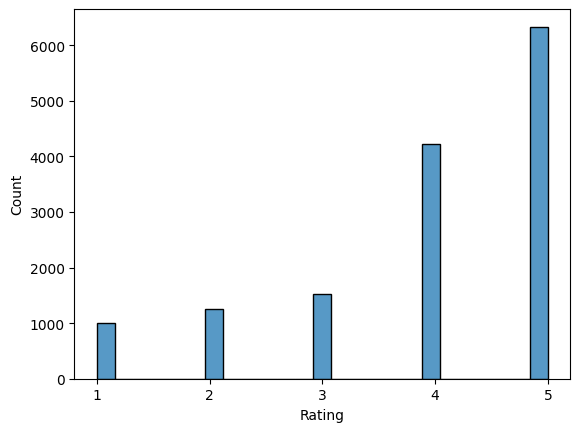

In [11]:
sns.histplot(df_train['Rating'], )
plt.xticks(range(1, 6))

In [12]:
df_train['Review'].values, 

(array(["foliage silhouette perfect european getaway hotel chic elegant friendly professional staff, room small well-appointed good use limited space, bed comfortable duvet nice pillows, complaint room reading lights bed did n't work, beware breakfast, expensive, mistakenly assumed breakfast included room thought taken morning coffees meals, good breakfast, internet fee 5 euro 5 minutes crazy not choice wanted confirm return flight home, room offers free wireless, recommend hotel just mindful extra charges, ca n't beat location, members",
        'characterized recommendng clean safe hotel husband stayed hotel colomba 3 nights stay florence, highlights staying rosanna runs hotel family staff, friendly helpful, gave information asked rosanna ticket reservations accademie uffizi, rosanna family live hotel premises feel bit safer makes feel like home, drawback live guests walk room/office living room room, sons sitting number occasions friendly walk, room clean, good job keeping spotless,

100%|██████████| 14338/14338 [00:00<00:00, 999400.58it/s]


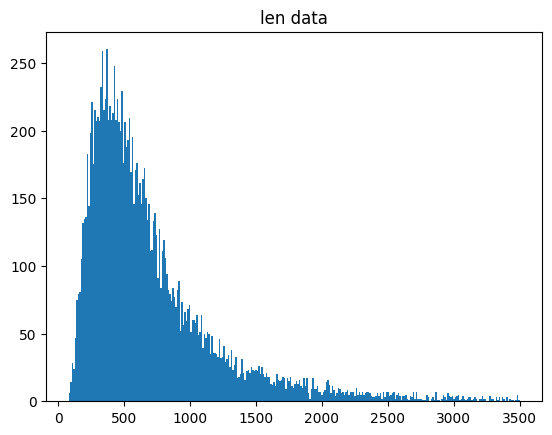

In [13]:
plt.hist([len(i) for i in tqdm(df_train['Review'].values) if len(i) < 3500], bins=300)
plt.title('len data')
plt.show()

In [14]:
sent_len = [len(i) for i in tqdm(df_train['Review'].values)]

100%|██████████| 14338/14338 [00:00<00:00, 924217.84it/s]


In [15]:
np.quantile(sent_len, 0.95)

1932.0

## Models

### Своя архитектура

In [16]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

### Bert

In [17]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_train['Review'], df_train['Rating'], test_size=0.2
)

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [19]:
# Создание датасета
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx] - 1  
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
    
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [20]:
# Создание DataLoader
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [21]:
# Инициализация модели
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

# Определение устройства (CPU или GPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [22]:
def train_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
    return total_loss / len(dataloader)

def eval_model(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)

            total_loss += loss.item()
            
    return total_loss / len(dataloader)

In [23]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = AdamW(model.parameters(), lr=2e-5)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
# Количество эпох
EPOCHS = 4

# Процесс обучения
train_losses = []
eval_losses = []

for epoch in tqdm(range(EPOCHS)):
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss = eval_model(model, val_loader, loss_fn, device)
    
    train_losses.append(train_loss)
    eval_losses.append(val_loss)

    print(f'Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

 25%|██▌       | 1/4 [05:38<16:54, 338.08s/it]

Epoch 1/4, Train Loss: 0.9117, Val Loss: 0.7773


 50%|█████     | 2/4 [11:25<11:27, 343.69s/it]

Epoch 2/4, Train Loss: 0.7129, Val Loss: 0.7975


 75%|███████▌  | 3/4 [17:14<05:45, 345.93s/it]

Epoch 3/4, Train Loss: 0.5584, Val Loss: 0.9396


100%|██████████| 4/4 [23:02<00:00, 345.72s/it]

Epoch 4/4, Train Loss: 0.3951, Val Loss: 0.9440


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

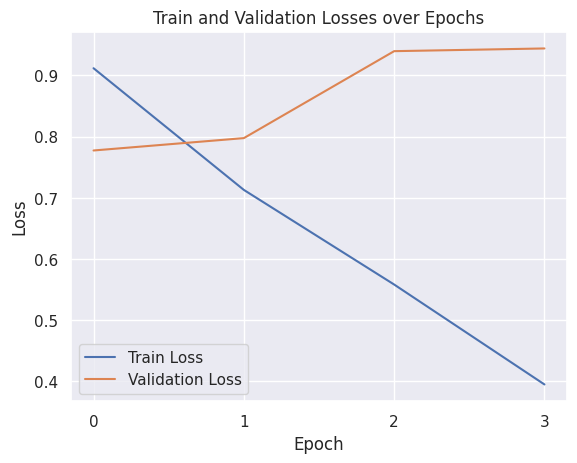

In [25]:
sns.set_theme()

sns.lineplot(train_losses, markers=True, label='Train Loss', dashes=True)
sns.lineplot(eval_losses, markers=True, label='Validation Loss', dashes=False)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses over Epochs')
plt.xticks(range(4))
plt.legend()
plt.show()

In [26]:
def predict(model, tokenizer, texts, true_labels, device):
    model.eval()
    predictions = []

    for text in tqdm(texts):
        encoding = tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predicted_class = torch.argmax(outputs.logits, dim=-1).item()
            predictions.append(predicted_class + 1)  # Приводим обратно к 1-5 классам

    # Вычисляем accuracy
    accuracy = accuracy_score(true_labels, predictions)
    
    return predictions, accuracy

In [27]:
predicted_labels, accuracy = predict(model, tokenizer, val_texts, val_labels, device)

print(f"Accuracy: {accuracy:.4f}")

100%|██████████| 2868/2868 [00:40<00:00, 71.30it/s]

Accuracy: 0.6583


# Обучение Bert для submission


In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Создание датасета
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx] - 1  
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [29]:
# Создание DataLoader
train_dataset = TextDataset(df_train['Review'], df_train['Rating'], tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [30]:
# Инициализация модели
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [31]:
# Количество эпох
EPOCHS = 2

# Процесс обучения
for epoch in tqdm(range(EPOCHS)):
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    
    print(f'Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss:.4f}')

 50%|█████     | 1/2 [05:49<05:49, 349.61s/it]

Epoch 1/2, Train Loss: 1.5834


100%|██████████| 2/2 [11:39<00:00, 349.67s/it]

Epoch 2/2, Train Loss: 1.5853


In [33]:
predicted_labels = predict(model, tokenizer, df_test['Review'], device)

100%|██████████| 6148/6148 [01:26<00:00, 71.27it/s]


### Submission

In [34]:
sample_submission['Rating'] = predicted_labels

In [35]:
sample_submission.to_csv('submission.csv', index=False)